# OOD Detection by Constrasting Shifted Instances (CSI)

This notebook demonstrates the process of detecting OOD images by measuring their CSI score and comparing it to a pre-computed threshold. This technique was developed in ["**CSI: Novelty Detection via Contrastive Learning on Distributionally Shifted Instances**"](
https://arxiv.org/abs/2007.08176) (NeurIPS 2020) by
[Jihoon Tack](https://jihoontack.github.io),
[Sangwoo Mo](https://sites.google.com/view/sangwoomo),
[Jongheon Jeong](https://sites.google.com/view/jongheonj),
and [Jinwoo Shin](http://alinlab.kaist.ac.kr/shin.html). We [created a fork](https://github.com/harvard-ac299r-final-project/CSI) of their [official PyTorch implementation](https://github.com/alinlab/CSI) and modified it to ingest and process our `bollworms` and `bollworms-clean` datasets. We trained CSI models on each of these datasets on a cluster and saved the resulting CSI scores in `ood-detection/notebooks/csi_scores` for convenience. Details about the training process can be made available upon request (POC: [Erin Tomlinson](mailto:erintomlinson90@gmail.com)).

## Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

## Navigate to `ood-detection` repository

In [2]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

# Replace [OOD_DETECTION_REPOSITORY] with the correct location
os.chdir('/content/drive/[OOD_DETECTION_REPOSITORY]')
!git pull

Mounted at /content/drive/
Already up to date.


## Load Precomputed CSI Scores

All of the analysis in this notebook can be performed using precomputed scores  on either the `bollworms` or `bollworms-clean` dataset (described in the main report) by changing the value of the `dataset` variable below.

In [21]:
# Select dataset of interest
dataset = 'bollworms' # ['bollworms', 'bollworms-clean']

# Load requested CSI scores
npzfile = np.load(f'notebooks/csi_scores/score_in_{dataset}_CSI.npz')

# Copy the scores into local variables for brevity
scores_train_id = npzfile['scores_train_id']
scores_train_ood = npzfile['scores_train_ood']
scores_test_id = npzfile['scores_test_id']
scores_test_ood = npzfile['scores_test_ood']

## Visualize distribution of CSI scores for train dataset

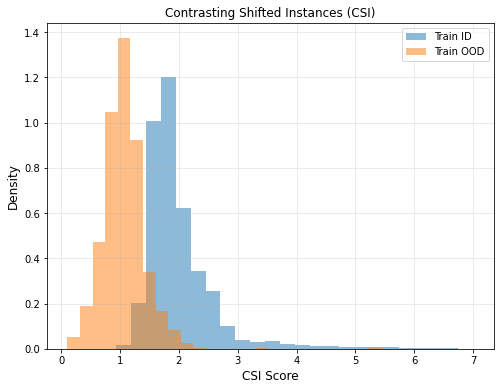

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(npzfile['scores_train_id'], bins=25, alpha=0.5, density=True, label='Train ID')
ax.hist(npzfile['scores_train_ood'], bins=25, alpha=0.5, density=True, label='Train OOD')
ax.set_xlabel('CSI Score', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title(f'Contrasting Shifted Instances (CSI)')
ax.legend()
ax.grid(alpha=0.3)

## Find optimal threshold using train set

Our goal is the use weighted logistic regression to find the best threshold at each layer. We use weighted logistic regression to compute class probabilities rather than using the CSI scores directly because there is strong class imbalance in our train and test sets (train set is approximately 90% ID and 10% OOD). Here we fit a weighted logistic regression model to the CSI scores in the train set, and compute the threshold that maximizes the macro-averaged F1 score. We will then use the threshold that gives us the highest macro-averaged F1 score overall for our final analysis on the test set.

In [23]:
from analysis.classifiers import get_auroc, get_f1_maximizing_threshold, get_classification_report
from sklearn.linear_model import LogisticRegression

# Fit weighted logistic regression model to the training data
logit_model = LogisticRegression(penalty='none', class_weight='balanced')
x_train = np.concatenate([scores_train_id, scores_train_ood]).reshape(-1, 1)
y_train = np.concatenate([np.ones_like(scores_train_id), np.zeros_like(scores_train_ood)])
logit_model.fit(x_train, y_train)

# Compute model-predicted ID probabilities, which we treat as our new anomaly 
# detection scores. Then use these scores to find the threshold that maximizes 
# macro-averaged F1.
scores_train_id = logit_model.predict_proba(x_train[y_train == 1])[:, 1]
scores_train_ood = logit_model.predict_proba(x_train[y_train == 0])[:, 1]
threshold, max_f1_score = get_f1_maximizing_threshold(scores_train_id, scores_train_ood)

print(f'Max F1 score on train set = {max_f1_score:.3f}, ID probability threshold = {threshold:.3f}')

Max F1 score on train set = 0.914, ID probability threshold = 0.198


## Use optimal threshold to evaluate on test set

Now that we have chosen our optimal threshold using the train set, we can finally evaluate our OOD detection performance on the test set. The output of this code cell was used to produce the primary table of results in our main report.

In [24]:
# Compute model-predicted ID probabilities on the test set using our best model.
x_test = np.concatenate([scores_test_id, scores_test_ood]).reshape(-1, 1)
y_test = np.concatenate([np.ones_like(scores_test_id), np.zeros_like(scores_test_ood)])
scores_test_id = logit_model.predict_proba(x_test[y_test == 1])[:, 1]
scores_test_ood = logit_model.predict_proba(x_test[y_test == 0])[:, 1]

# Compute and report all classifier metrics of interest 
auc = get_auroc(scores_test_id, scores_test_ood)
class_report, conf_matrix = get_classification_report(scores_test_id, scores_test_ood, threshold)
per_class_accuracy = conf_matrix.diagonal()/conf_matrix.sum(axis=1)
tn, fp, fn, tp = conf_matrix.ravel()

print(f'Classification report on test set [Score: CSI]:')
print('')
print(class_report)
print(f'OOD accuracy: {per_class_accuracy[0]:.3f}')
print(f' ID accuracy: {per_class_accuracy[1]:.3f}')
print('')
print('Breakdown:', {'TN': tn, 'FP': fp, 'FN': fn, 'TP': tp})
print('')
print(f'AUC: {auc:.3f}')
print('')

Classification report on test set [Score: CSI]:

              precision    recall  f1-score   support

      OOD: 0      0.681     0.731     0.705       108
       ID: 1      0.966     0.957     0.962       865

    accuracy                          0.932       973
   macro avg      0.824     0.844     0.834       973
weighted avg      0.935     0.932     0.933       973

OOD accuracy: 0.731
 ID accuracy: 0.957

Breakdown: {'TN': 79, 'FP': 29, 'FN': 37, 'TP': 828}

AUC: 0.951



## Visualize test set performance

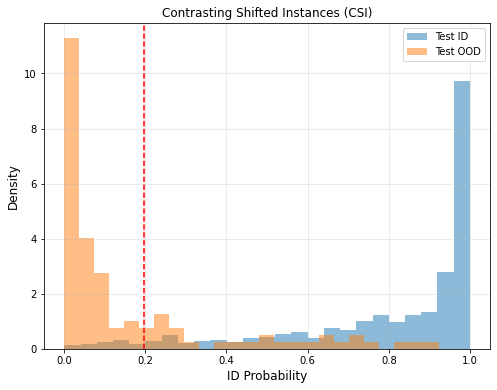

In [25]:
# First in terms of ID probabilities from weighted logistic regression model
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(scores_test_id, bins=25, alpha=0.5, density=True, label='Test ID')
ax.hist(scores_test_ood, bins=25, alpha=0.5, density=True, label='Test OOD')
ax.axvline(threshold, color='r', linestyle='--', label='_nolegend_')
ax.set_xlabel('ID Probability', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title(f'Contrasting Shifted Instances (CSI)')
ax.legend()
ax.grid(alpha=0.3)

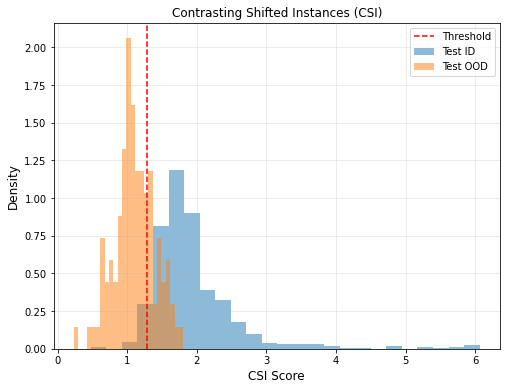

In [26]:
# Then on the original scale in terms of CSI scores
logit = lambda p: np.log(p/(1-p))
threshold_CSI = ((logit(threshold) - logit_model.intercept_)/logit_model.coef_[0][0])[0]
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(npzfile['scores_test_id'], bins=25, alpha=0.5, density=True, label='Test ID')
ax.hist(npzfile['scores_test_ood'], bins=25, alpha=0.5, density=True, label='Test OOD')
ax.axvline(threshold_CSI, color='r', linestyle='--', label='Threshold')
ax.set_xlabel('CSI Score', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title(f'Contrasting Shifted Instances (CSI)')
ax.legend()
ax.grid(alpha=0.3)

## Evaluate on external OOD datasets

We have also precomputed CSI scores for the `stanford_dogs` and `flowers102` datasets.

In [27]:
# Stores precomputed CSI scores for external datasets in one dictionary 
external_scores_dict = {'Dogs': npzfile['scores_stanford_dogs'], 'Flowers': npzfile['scores_flowers102']}

for label, scores_external_ood in external_scores_dict.items():

    # Compute model-predicted ID probabilities on the test set using our best model.
    scores_external_ood = logit_model.predict_proba(scores_external_ood.reshape(-1, 1))[:, 1]

    # Compute the fraction of images in this dataset that our model would label as OOD.
    external_ood_accuracy = 1.0 - np.mean(scores_external_ood > threshold)
    print(f'{label} (OOD) accuracy: {external_ood_accuracy:.3f}')

Dogs (OOD) accuracy: 0.977
Flowers (OOD) accuracy: 0.979
